In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import operator
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib.image import imread

In [2]:
dic = {}
M =6
n=0
for i in range(1,M+1):
    for j in range(1,M+1):
        n+=1
        dic[n,'x'] =i
        dic[n,'y'] =j  
N = n 

In [3]:
def dist(i,j):
    return sqrt( (dic[i,'x']-dic[j,'x'])**2 +  (dic[i,'y']-dic[j,'y'])**2  )
connect = {}
for i in range(1,1+N):
    for j in range(1,1+N):
        if dist(i,j) ==1:
            connect[i,j] = 1

In [4]:
upper_bound = {}
for i in range(1,1+N):
    upper_bound[i] = 1 + sum(1 for j in range(1,1+N) if (i,j) in connect)

Nmax = max(upper_bound.values())

In [5]:
for j in range(1,9):
    if (5,j) in connect: # and 5<=upper_bound[j]:
        print(j, upper_bound[j])

4 4
6 3


In [6]:
model = AbstractModel()
model.i = RangeSet(N)
model.j = Set(initialize= model.i)
model.n = RangeSet(Nmax)
def rule_w(model,i,j):
    return connect.get((i,j),0)
model.w = Param(model.i,model.j,initialize= rule_w)
model.y = Var(model.i, model.n, domain = Binary)

def rule_c2(model,i):
    return sum(model.y[i,n] for n in model.n if n <= upper_bound[i] ) ==1
model.C2 = Constraint(model.i, rule=rule_c2)

def rule_c3(model,i,n):
    if n <= upper_bound[i] and sum(1 for j in model.j if (i,j) in connect and n<=upper_bound[j] )>0 and sum(1 for m in model.n if n<m <= upper_bound[i]):
        return sum(model.y[j,n] for j in model.j if (i,j) in connect and n<=upper_bound[j] ) >= sum(model.y[i,m] for m in model.n if n<m <= upper_bound[i])
    else:
        return Constraint.Skip
model.C3 = Constraint(model.i, model.n, rule=rule_c3)

def rule_OF(model):
    return sum( n*model.y[i,n] for n in model.n for i in model.i if n <=upper_bound[i] )

model.obj1 = Objective(rule=rule_OF, sense=maximize)

In [7]:
opt = SolverFactory('cbc')
opt.options = {'sec': 300, 'threads': 6, 'ratio': 0.05}

instance = model.create_instance()  

In [8]:
results = opt.solve(instance) # solves and updates instance
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))
print(value(instance.obj1) )

this is feasible and optimal
93.0


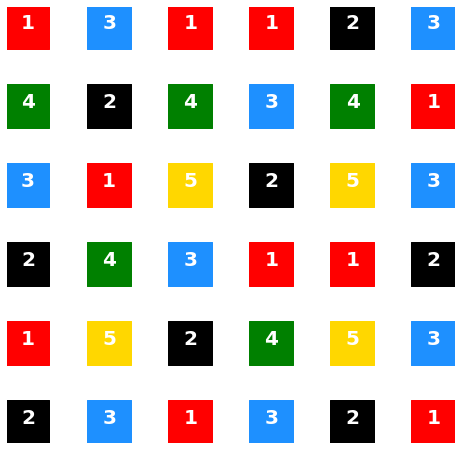

In [9]:
plt.figure(figsize=(8,8))
KOLOR = ['r', 'k', 'dodgerblue', 'g', 'gold', 'pink','dodgerblue','orange','brown','olive']

for i in instance.i:
    m = int(value(sum(n*instance.y[i,n] for n in instance.n if n <=upper_bound[i] ) ))
    plt.scatter(dic[i,'x'], dic[i,'y'], s= 2000 , marker ='s', c=KOLOR[m-1])
    plt.text(dic[i,'x']-0.08, dic[i,'y']-0.02, s= str(m) , c='w', fontsize=20, fontweight='bold')

plt.axis('off')
plt.savefig('neighbors '+ str(Nmax)+  ' .png', format='png', dpi=200)

plt.show()